In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

CPU Rate: 1.866e-05
GPU Rate: 0.00010747


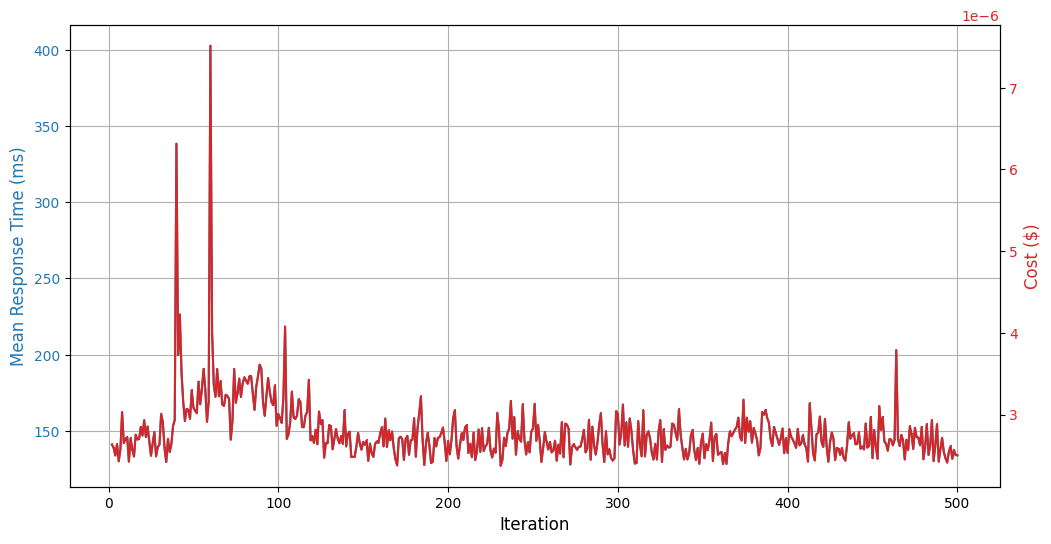

In [2]:
csv_files_auto = glob.glob("./data/auto/*response_times.csv")

dfs_auto = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_auto]

combined_auto = pd.concat(dfs_auto, axis=1)
combined_auto.columns = [f"run_{i + 1}" for i in range(len(dfs_auto))]

combined_auto.head()

row_means = pd.DataFrame({
    "iteration": range(1, len(combined_auto) + 1),
    "mean_response_time": combined_auto.mean(axis=1).values
})

row_means["response_time_s"] = row_means["mean_response_time"] / 1000


response_time_sum_auto = row_means.mean(axis=1).sum() / 1000

# remove first row (cold start) for better visualization
row_means = row_means.iloc[1:]

# assign rates
cpu_rate = 0.00001435 + 0.00000431
gpu_rate = 0.00000632 + 0.00000615 + 0.000095

print(f"CPU Rate: {cpu_rate}")
print(f"GPU Rate: {gpu_rate}")

# calculate cost
row_means["cost"] = row_means.apply(
    lambda row: row["response_time_s"] * cpu_rate,
    axis=1
)

# plot with iteration on x axis and mean_response_time on y axis
# First y-axis: response time
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(row_means["iteration"], row_means["mean_response_time"], color="tab:blue", marker=',')
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("Mean Response Time (ms)", fontsize=12, color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True)

# Cost graph is the same since we are only on one execution mode

# Second y-axis: cost
ax2 = ax1.twinx()
ax2.plot(row_means["iteration"], row_means["cost"], color="tab:red", marker=',')
ax2.set_ylabel("Cost ($)", fontsize=12, color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.show()


In [3]:
# Export to csv

df_lines = pd.DataFrame({
    "response_time": row_means["mean_response_time"],
    "cost": row_means["cost"]
})

# Save to CSV
df_lines.to_csv("response_time_chart.csv", index_label="Index")

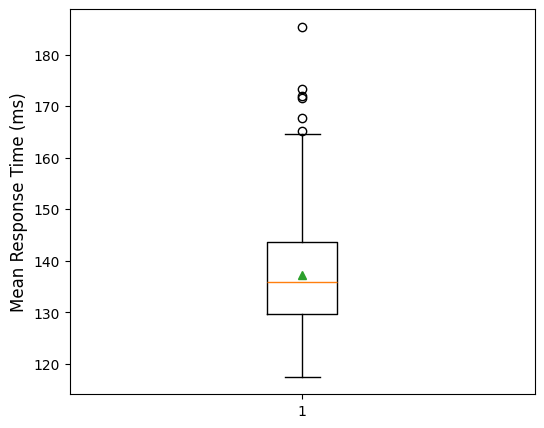

In [4]:
# GPU Boxplot
csv_files_gpu = glob.glob("./data/gpu/*response_times.csv")

dfs_gpu = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_gpu]

combined_gpu = pd.concat(dfs_gpu, axis=1)
combined_gpu.columns = [f"run_{i + 1}" for i in range(len(dfs_gpu))]

response_time_sum_gpu = combined_gpu.mean(axis=1).sum() / 1000

# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_gpu = combined_gpu.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_gpu, showmeans=True)

# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()

In [5]:
# GPU Cost Calculation

results = []

for df in dfs_gpu:
    df = df.copy()
    df["response_time_s"] = df["response_time_ms"] / 1000

    sum = df["response_time_s"].sum()
    results.append(sum)

seconds_gpu = pd.DataFrame(results).fillna(0)
seconds_gpu += 30

cost_per_run_gpu = seconds_gpu * gpu_rate
mean_cost_gpu = cost_per_run_gpu.mean()

cost_gpu = mean_cost_gpu.sum()

print(cost_gpu)

0.01191889580297947


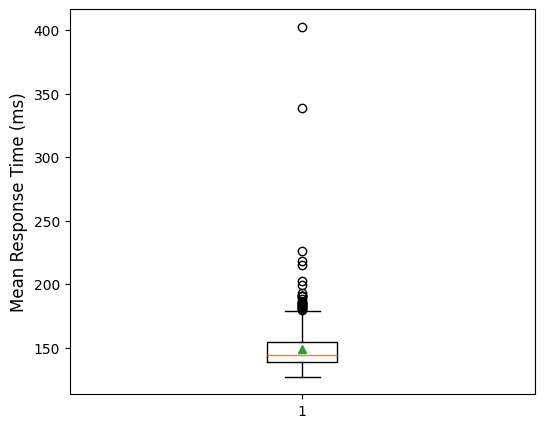

In [6]:
# Auto Boxplot
combined_auto = pd.concat(dfs_auto, axis=1)
combined_auto.columns = [f"run_{i + 1}" for i in range(len(dfs_auto))]

combined_auto.head()


# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_auto = combined_auto.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_auto, showmeans=True)

# Add title and labels
# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()

In [7]:
# Auto Cost Calculation
results = []

for df in dfs_auto:
    df = df.copy()
    df["response_time_s"] = df["response_time_ms"] / 1000

    sum = df["response_time_s"].sum()
    results.append(sum)

seconds_auto = pd.DataFrame(results).fillna(0)
seconds_auto += 30

cost_per_run_auto = seconds_auto * cpu_rate
mean_cost_auto = cost_per_run_auto.mean()

cost_auto = mean_cost_auto.sum()

print(cost_auto)

0.00200339217436409


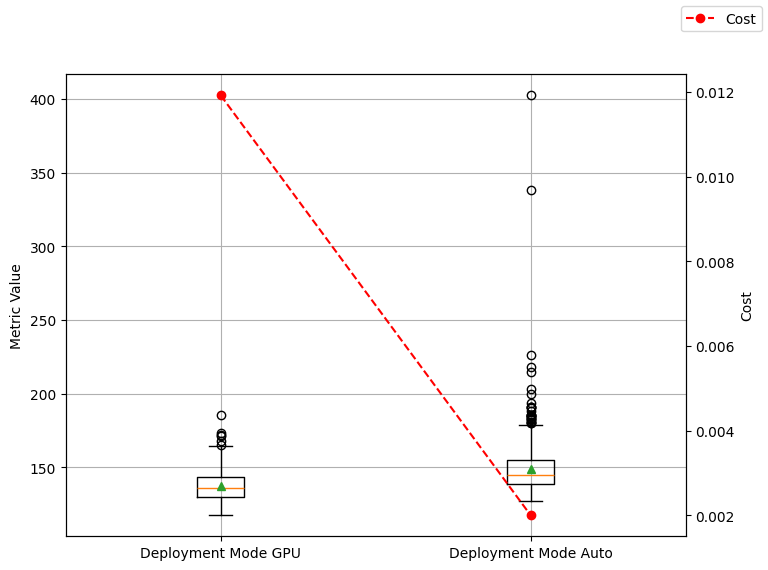

In [8]:
# Combine both CPU and GPU data for comparison

data = [row_means_without_coldstart_gpu, row_means_without_coldstart_auto]

fig, ax1 = plt.subplots(figsize=(8,6))

# Boxplots on left y-axis
ax1.boxplot(
    data,
    tick_labels=["Deployment Mode GPU", "Deployment Mode Auto"],
    showmeans=True
)
ax1.set_ylabel("Metric Value")

costs = [cost_gpu, cost_auto]

positions = [1, 2]

# Add a second axis for costs
ax2 = ax1.twinx()
ax2.plot(positions, costs, "ro--", label="Cost")  # red dotted line with markers
ax2.set_ylabel("Cost")

ax1.grid(True)
fig.legend()
plt.show()


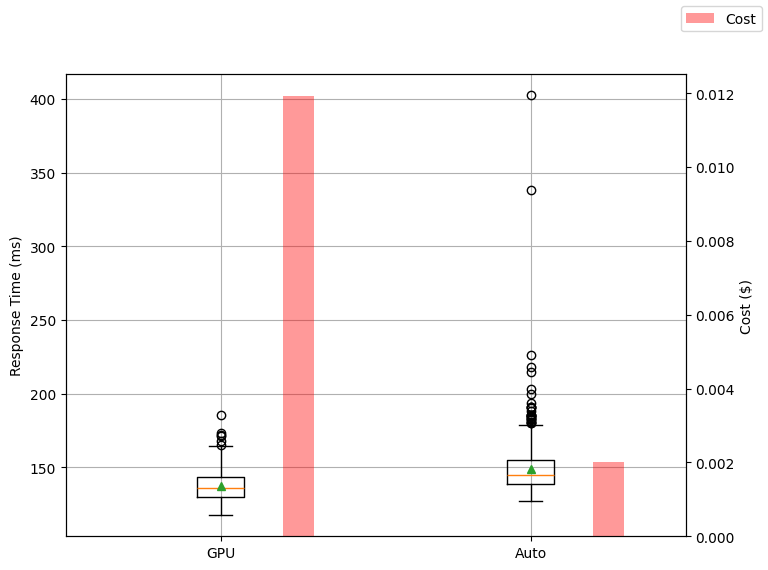

In [9]:
fig, ax1 = plt.subplots(figsize=(8,6))

positions = [1, 2]
ax1.boxplot(
    data,
    tick_labels=["GPU", "Auto"],
    showmeans=True,
    positions=positions
)
ax1.set_ylabel("Response Time (ms)")

# Second axis for costs
ax2 = ax1.twinx()

# Shifted & thinner bars
bar_width = 0.1
offset = 0.25  # shift to the right
ax2.bar(
    [p + offset for p in positions],
    costs,
    width=bar_width,
    color="red",
    alpha=0.4,
    label="Cost"
)

ax2.set_ylabel("Cost ($)")
ax1.grid(True)
fig.legend()
plt.show()


In [10]:
# Export to CSV
rows = []
modes = ["GPU", "Auto"]

for mode, values in zip(modes, data):
    for v in values:
        rows.append({"Execution Mode": mode, "Response Time": v})

df_boxplot = pd.DataFrame(rows)
df_costs = pd.DataFrame({
    "Execution Mode": modes,
    "Cost": costs
})

# Save
df_boxplot.to_csv("boxplot_data.csv", index=False)
df_costs.to_csv("costs.csv", index=False)



In [12]:
# get mean of data[0]and data[1]
mean_gpu = data[0].mean()
mean_auto = data[1].mean()
print(f"Mean GPU: {mean_gpu:.2f} ms")
print(f"Mean Auto: {mean_auto:.2f} ms")

Mean GPU: 137.22 ms
Mean Auto: 149.16 ms


In [11]:
# Calculate and print summary statistics

# mean of first values
auto_coldstart = combined_auto.iloc[0].mean()
gpu_coldstart = combined_gpu.iloc[0].mean()


print(f"Auto Cold Start Mean: {auto_coldstart:.2f} ms")
print(f"GPU Cold Start Mean: {gpu_coldstart:.2f} ms")

Auto Cold Start Mean: 2932.61 ms
GPU Cold Start Mean: 12433.15 ms
